# Analisis de datos en Julia

In [1]:
using CSV
using DataFrames
using Dates
using Plots

In [2]:
# Paso 1; Buscamos la localización del dataset
URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

# Paso 2: Establecemos el lugar para descargarlo

path = pwd()*"/Data/confirmed.csv"

# Paso 3: Descarga el dataset en la ruta asignada
download(URL, path)

"/home/silverwolf/Documents/Proyectos AI/JuliaCVML/Semana 1/Data/confirmed.csv"

In [3]:
# Paso 4 : Abre el CSV y lo introduce en un dataframe
df = CSV.File(path)|> DataFrame

,Province/State,Country/Region,Lat,Long,1/22/20
,String?,String,Float64?,Float64?,Int64
1,missing,Afghanistan,33.9391,67.71,0
2,missing,Albania,41.1533,20.1683,0
3,missing,Algeria,28.0339,1.6596,0
4,missing,Andorra,42.5063,1.5218,0
5,missing,Angola,-11.2027,17.8739,0
6,missing,Antarctica,-71.9499,23.347,0
7,missing,Antigua and Barbuda,17.0608,-61.7964,0
8,missing,Argentina,-38.4161,-63.6167,0
9,missing,Armenia,40.0691,45.0382,0


In [4]:
first(df, 10)

,Province/State,Country/Region,Lat,Long,1/22/20
,String?,String,Float64?,Float64?,Int64
1,missing,Afghanistan,33.9391,67.71,0
2,missing,Albania,41.1533,20.1683,0
3,missing,Algeria,28.0339,1.6596,0
4,missing,Andorra,42.5063,1.5218,0
5,missing,Angola,-11.2027,17.8739,0
6,missing,Antarctica,-71.9499,23.347,0
7,missing,Antigua and Barbuda,17.0608,-61.7964,0
8,missing,Argentina,-38.4161,-63.6167,0
9,missing,Armenia,40.0691,45.0382,0


In [5]:
select!(df, Not(["Province/State", "Lat", "Long"]))

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20
,String,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,Afghanistan,0,0,0,0,0,0,0
2,Albania,0,0,0,0,0,0,0
3,Algeria,0,0,0,0,0,0,0
4,Andorra,0,0,0,0,0,0,0
5,Angola,0,0,0,0,0,0,0
6,Antarctica,0,0,0,0,0,0,0
7,Antigua and Barbuda,0,0,0,0,0,0,0
8,Argentina,0,0,0,0,0,0,0
9,Armenia,0,0,0,0,0,0,0


In [6]:
df[ df."Country/Region".=="Australia", :]

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20
,String,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,Australia,0,0,0,0,0,0,0,0
2,Australia,0,0,0,0,3,4,4,4
3,Australia,0,0,0,0,0,0,0,0
4,Australia,0,0,0,0,0,0,0,1
5,Australia,0,0,0,0,0,0,0,0
6,Australia,0,0,0,0,0,0,0,0
7,Australia,0,0,0,0,1,1,1,1
8,Australia,0,0,0,0,0,0,0,0


```Julia
using Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Dates")
Pkg.add("Plots")
Pkg.add("Statistics")
Pkg.add("GLM")
Pkg.add("StatsModels")
```

In [7]:
first(df,10)

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20
,String,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,Afghanistan,0,0,0,0,0,0,0
2,Albania,0,0,0,0,0,0,0
3,Algeria,0,0,0,0,0,0,0
4,Andorra,0,0,0,0,0,0,0
5,Angola,0,0,0,0,0,0,0
6,Antarctica,0,0,0,0,0,0,0
7,Antigua and Barbuda,0,0,0,0,0,0,0
8,Argentina,0,0,0,0,0,0,0
9,Armenia,0,0,0,0,0,0,0


In [8]:
grp = groupby(df, "Country/Region")
column_names = names(grp)
date_columns = column_names[2:end] # Selecciona todas las columnas excepto la primera
df = combine(grp, date_columns .=> sum .=> date_columns)

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20
,String,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,Afghanistan,0,0,0,0,0,0,0
2,Albania,0,0,0,0,0,0,0
3,Algeria,0,0,0,0,0,0,0
4,Andorra,0,0,0,0,0,0,0
5,Angola,0,0,0,0,0,0,0
6,Antarctica,0,0,0,0,0,0,0
7,Antigua and Barbuda,0,0,0,0,0,0,0
8,Argentina,0,0,0,0,0,0,0
9,Armenia,0,0,0,0,0,0,0


In [9]:
df = DataFrames.stack(
    df,
    Not("Country/Region"),
    "Country/Region",
    variable_name="Date",
    value_name="Cases",
)

,Country/Region,Date,Cases
,String,String,Int64
1,Afghanistan,1/22/20,0
2,Albania,1/22/20,0
3,Algeria,1/22/20,0
4,Andorra,1/22/20,0
5,Angola,1/22/20,0
6,Antarctica,1/22/20,0
7,Antigua and Barbuda,1/22/20,0
8,Argentina,1/22/20,0
9,Armenia,1/22/20,0


In [10]:
df.Date = Dates.Date.(df.Date |> Array, Dates.DateFormat("m/d/Y")) .+ Dates.Year(2000)

170344-element Vector{Date}:
 2020-01-22
 2020-01-22
 2020-01-22
 2020-01-22
 2020-01-22
 2020-01-22
 2020-01-22
 2020-01-22
 2020-01-22
 2020-01-22
 2020-01-22
 2020-01-22
 2020-01-22
 ⋮
 2022-05-26
 2022-05-26
 2022-05-26
 2022-05-26
 2022-05-26
 2022-05-26
 2022-05-26
 2022-05-26
 2022-05-26
 2022-05-26
 2022-05-26
 2022-05-26

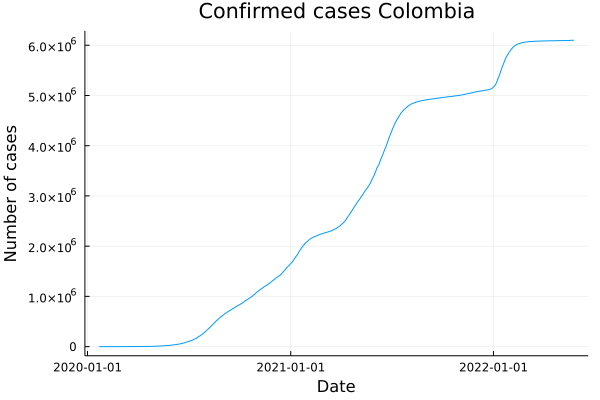

In [11]:
plot(
    df[df."Country/Region" .== "Colombia", :Date],
    df[df."Country/Region" .== "Colombia", :Cases],
    title = "Confirmed cases Colombia",
    xlabel = "Date",
    ylabel = "Number of cases",
    legend = false,
)

# Modelos básicos de Machine learning en Julia

## Importando los datos en Julia

In [12]:
using CSV,DataFrames,Statistics,Random,Plots

In [13]:
path=pwd()*"/Data/clean_dataset.csv"

"/home/silverwolf/Documents/Proyectos AI/JuliaCVML/Semana 1/Data/clean_dataset.csv"

In [14]:
function detect_strings(df)
   str=[String31,String7,String15]
   vector=eltype.(eachcol(df)).==str[1]
   elements=[]
   columns=names(df)
   for i in 2:length(str)
       vector+=eltype.(eachcol(df)).==str[i]
    end

   for j in 1:length(columns)
       if vector[j]==0
        push!(elements,columns[j])
       end
    end
    return elements
end

detect_strings (generic function with 1 method)

In [15]:
df= CSV.File(path)|> DataFrame #Dataframe(CSV.File(path))
first(df,10)

,Gender,Age,Debt,Married,BankCustomer,Industry,Ethnicity
,Int64,Float64,Float64,Int64,Int64,String31,String7
1,1,30.83,0.0,1,1,Industrials,White
2,0,58.67,4.46,1,1,Materials,Black
3,0,24.5,0.5,1,1,Materials,Black
4,1,27.83,1.54,1,1,Industrials,White
5,1,20.17,5.625,1,1,Industrials,White
6,1,32.08,4.0,1,1,CommunicationServices,White
7,1,33.17,1.04,1,1,Transport,Black
8,0,22.92,11.585,1,1,InformationTechnology,White
9,1,54.42,0.5,0,0,Financials,Black


In [16]:
union(df[:,"Industry"])

14-element Vector{String31}:
 "Industrials"
 "Materials"
 "CommunicationServices"
 "Transport"
 "InformationTechnology"
 "Financials"
 "Energy"
 "Real Estate"
 "Utilities"
 "ConsumerDiscretionary"
 "Education"
 "ConsumerStaples"
 "Healthcare"
 "Research"

## Filtrado y visualización

In [17]:
select!(df,detect_strings(df))

,Gender,Age,Debt,Married,BankCustomer,YearsEmployed,PriorDefault,Employed
,Int64,Float64,Float64,Int64,Int64,Float64,Int64,Int64
1,1,30.83,0.0,1,1,1.25,1,1
2,0,58.67,4.46,1,1,3.04,1,1
3,0,24.5,0.5,1,1,1.5,1,0
4,1,27.83,1.54,1,1,3.75,1,1
5,1,20.17,5.625,1,1,1.71,1,0
6,1,32.08,4.0,1,1,2.5,1,0
7,1,33.17,1.04,1,1,6.5,1,0
8,0,22.92,11.585,1,1,0.04,1,0
9,1,54.42,0.5,0,0,3.96,1,0


In [28]:
cor(Matrix(df)

LoadError: syntax: incomplete: premature end of input

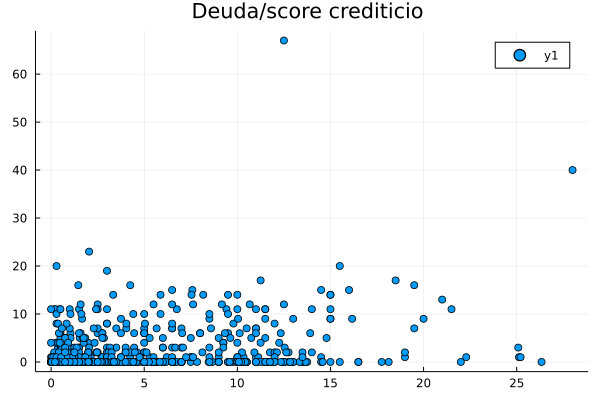

In [19]:
scatter(df[:,"Debt"], df[:,"CreditScore"], title =  "Deuda/score crediticio ")

In [20]:
describe(df)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,Gender,0.695652,0,1.0,1,0,Int64
2,Age,31.5141,13.75,28.46,80.25,0,Float64
3,Debt,4.75872,0.0,2.75,28.0,0,Float64
4,Married,0.76087,0,1.0,1,0,Int64
5,BankCustomer,0.763768,0,1.0,1,0,Int64
6,YearsEmployed,2.22341,0.0,1.0,28.5,0,Float64
7,PriorDefault,0.523188,0,1.0,1,0,Int64
8,Employed,0.427536,0,0.0,1,0,Int64
9,CreditScore,2.4,0,0.0,67,0,Int64


# Separación de los datos de entrenamiento/test

In [21]:
sample = randsubseq(1:size(df,1), 0.75)
train = df[sample, :]
notsample = [i for i in 1:size(df,1) if isempty(searchsorted(sample, i))]
test = df[notsample, :]

,Gender,Age,Debt,Married,BankCustomer,YearsEmployed,PriorDefault,Employed
,Int64,Float64,Float64,Int64,Int64,Float64,Int64,Int64
1,0,22.92,11.585,1,1,0.04,1,0
2,1,54.42,0.5,0,0,3.96,1,0
3,1,29.92,1.835,1,1,4.335,1,0
4,1,36.67,4.415,0,0,0.25,1,1
5,0,23.25,5.875,1,1,3.17,1,1
6,1,21.83,0.25,1,1,0.665,1,0
7,1,25.0,11.25,1,1,2.5,1,1
8,0,47.0,13.0,1,1,5.165,1,1
9,1,56.58,18.5,1,1,15.0,1,1


## Primeros modelos simples

In [22]:
using GLM

In [23]:
fm = @formula(Approved ~ Gender+ Age+ Debt+ Married+ BankCustomer+ YearsEmployed+ PriorDefault+ Employed+ CreditScore+ DriversLicense+ ZipCode+ Income)

FormulaTerm
Response:
  Approved(unknown)
Predictors:
  Gender(unknown)
  Age(unknown)
  Debt(unknown)
  Married(unknown)
  BankCustomer(unknown)
  YearsEmployed(unknown)
  PriorDefault(unknown)
  Employed(unknown)
  CreditScore(unknown)
  DriversLicense(unknown)
  ZipCode(unknown)
  Income(unknown)

In [24]:
logit = glm(fm, train, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

Approved ~ 1 + Gender + Age + Debt + Married + BankCustomer + YearsEmployed + PriorDefault + Employed + CreditScore + DriversLicense + ZipCode + Income

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────
                       Coef.    Std. Error      z  Pr(>|z|)      Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────────────────
(Intercept)     -1.81727       0.322125     -5.64    <1e-07   -2.44862      -1.18591
Gender           0.18248       0.16856       1.08    0.2790   -0.147891      0.512851
Age             -0.00851449    0.00705534   -1.21    0.2275   -0.0223427     0.00531373
Debt            -0.00880722    0.0172242    -0.51    0.6091   -0.042566      0.0249515
Marrie

In [25]:
@time glm(fm, train , Binomial(),ProbitLink())

  0.010504 seconds (1.38 k allocations: 463.406 KiB)


StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

Approved ~ 1 + Gender + Age + Debt + Married + BankCustomer + YearsEmployed + PriorDefault + Employed + CreditScore + DriversLicense + ZipCode + Income

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────
                       Coef.    Std. Error      z  Pr(>|z|)      Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────────────────
(Intercept)     -1.81727       0.322125     -5.64    <1e-07   -2.44862      -1.18591
Gender           0.18248       0.16856       1.08    0.2790   -0.147891      0.512851
Age             -0.00851449    0.00705534   -1.21    0.2275   -0.0223427     0.00531373
Debt            -0.00880722    0.0172242    -0.51    0.6091   -0.042566      0.0249515
Marrie

In [26]:
pred=predict(logit,test)
prediction_class=[if x<0.5 0 else 1 end for x in pred]
df_result=test[:,"Approved"]
println("Terminado")

Terminado


In [27]:
prediction_correctly= prediction_class.== df_result
accuracy=mean(prediction_correctly)*100
println("El modelo tuvo una precisión del "*string(accuracy)*"%" )

El modelo tuvo una precisión del 85.25641025641025%
